In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt
import iris.quickplot as qplt

import matplotlib.pyplot as plt
import cartopy.crs as ccrs  
import mo_pack
from matplotlib import ticker, cm
import iris.analysis.cartography
import os
import subprocess
import pandas as pd

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import ConnectionPatch

In [2]:
warnings.filterwarnings("ignore")

# Importing the data, specifically mixing ratios, temperature and pressure

In [3]:
pcb_b = iris.load('data/pcb_tl_o3circ_8340_900_spec.nc')

# Defining functions to spatially average the data

In [229]:
def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

#Half the dayside, half the nightside to mimic emission spectrum at phase 90deg in orbit
def spectral_hemi_sep(cube):

    termcube=cube.extract(iris.Constraint(longitude=lambda v: 0 <= v <= 180, 
                                    latitude=lambda v: -90 <= v <= 90))
    termcube2=cube.extract(iris.Constraint(longitude=lambda v: 180 <= v <= 360,
                                    latitude=lambda v: -90 <= v <= 90))
    termmean_1 = meridional_mean(zonal_mean(termcube))
    termmean_2 = meridional_mean(zonal_mean(termcube2))
    return termmean_1, termmean_2

#Extracting terminator region +-15 degrees to create transmission spectra
def spectral_term_sep(cube):
    termcube=cube.extract(iris.Constraint(longitude=lambda v: -105 <= v <= -75 or 75 <= v <= 105,
                                    latitude=lambda v: -90 <= v <= 90))
    #nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
    #                                latitude=lambda v: -90 <= v <= 90))
    termcube2=cube.extract(iris.Constraint(longitude=lambda v: -90 <= v <= 90,
                                    latitude=lambda v: -90 <= v <= -85 or 85 <= v <= 90))
    termmean_1 = meridional_mean(zonal_mean(termcube))
    termmean_2 = meridional_mean(zonal_mean(termcube2))
    #nightmean = meridional_mean(zonal_mean(nightcube)) 
    termmean = (termmean_1+termmean_2)/2
    return termmean

# Function to plot profiles of mixing ratios, process these through PSG API and get back contrasts as a function of wavelength for 5-20 micron

## For PSG see https://psg.gsfc.nasa.gov/index.php

In [128]:
n_colors = 10
colours = cm.tab10(np.linspace(0, 1, n_colors))

def replace_lines(file_path, start_line, end_line, replacement_file_path, new_file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    with open(replacement_file_path, 'r') as replacement_file:
        replacement_lines = replacement_file.readlines()

    lines[start_line - 1:end_line] = replacement_lines

    with open(new_file_path, 'w') as new_file:
        new_file.writelines(lines)
        
def plot_mixratz(cubes, time_slice_l=0, time_slice_u=-1, transmission=False, time_mean=False,tl_coord=False):            
    for cube in cubes:
        if cube.standard_name =='air_pressure':
            pres_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            pres_cube=pres_cube.collapsed('t', iris.analysis.MEAN)
        if cube.standard_name =='air_temperature':
            temp_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            temp_cube=temp_cube.collapsed('t', iris.analysis.MEAN)
        if cube.long_name == 'O3 MASS MIXING RATIO':
            vmr = cube[time_slice_l:time_slice_u,:,:,:].copy()
            vmr = vmr.collapsed('t', iris.analysis.MEAN)*29.3/48
        if cube.standard_name =='specific_humidity':
            sh_cube = cube[time_slice_l:time_slice_u,:,:,:].copy()
            sh_cube=sh_cube.collapsed('t', iris.analysis.MEAN)  
        if cube.long_name == 'NO MASS MIXING RATIO':
            novmr = cube[time_slice_l:time_slice_u,:,:,:].copy()
            novmr = novmr.collapsed('t', iris.analysis.MEAN)*29.3/30.01
        if cube.long_name == 'N2O MASS MIXING RATIO':
            n2ovmr = cube[time_slice_l:time_slice_u,:,:,:].copy()
            n2ovmr = n2ovmr.collapsed('t', iris.analysis.MEAN)*29.3/44.013
        if cube.long_name == 'Stash code = 34996':
            no2vmr = cube[time_slice_l:time_slice_u,:,:,:].copy()
            no2vmr = no2vmr.collapsed('t', iris.analysis.MEAN)*29.3/46.0055
        if cube.long_name == 'HONO2 MASS MIXING RATIO':
            hno3vmr = cube[time_slice_l:time_slice_u,:,:,:].copy()
            hno3vmr = hno3vmr.collapsed('t', iris.analysis.MEAN)*29.3/63.0128
    if transmission==True:
        p_term1 = spectral_term_sep(pres_cube)
        t_term1 = spectral_term_sep(temp_cube)
            
        o3_term1 = spectral_term_sep(vmr)
        h2o_term1 = spectral_term_sep(sh_cube)

        no_term1 = spectral_term_sep(novmr)
        no2_term1 = spectral_term_sep(no2vmr)
        n2o_term1 = spectral_term_sep(n2ovmr)
        hno3_term1 = spectral_term_sep(hno3vmr)
        obs_name='trans'
    else: 
        p_term1, p_term2 = spectral_hemi_sep(pres_cube)
        t_term1, t_term2 = spectral_hemi_sep(temp_cube)
            
        o3_term1, o3_term2 = spectral_hemi_sep(vmr)
        h2o_term1, h2o_term2 = spectral_hemi_sep(sh_cube)

        no_term1, no_term2 = spectral_hemi_sep(novmr)
        no2_term1, no2_term2 = spectral_hemi_sep(no2vmr)
        n2o_term1, n2o_term2 = spectral_hemi_sep(n2ovmr)
        hno3_term1, hno3_term2 = spectral_hemi_sep(hno3vmr)
        obs_name='hemi'

    plt.figure(figsize=(12,8))
    plt.subplot(1, 1, 1)
    plt.axvline(0.78084*(29.3/28.0134), color=colours[0], ls='--', label='N2')
    plt.axvline(0.2314*(29.3/31.9898), color=colours[1], ls='--', label='O2')
    plt.axvline(5.941e-4*(29.3/44.01), color=colours[2], ls='--', label='CO2')

    iplt.plot(o3_term1[:], o3_term1.coord("Hybrid height"), color=colours[3], ls='-', label='O3')
    iplt.plot(h2o_term1[:], h2o_term1.coord("Hybrid height"), color=colours[4], ls='-', label='H2O')
    iplt.plot(no_term1[:], no_term1.coord("Hybrid height"), color=colours[5], ls='-', label='NO')
    iplt.plot(no2_term1[:], no2_term1.coord("Hybrid height"), color=colours[6], ls='-', label='NO2')
    iplt.plot(n2o_term1[:], n2o_term1.coord("Hybrid height"), color=colours[7], ls='-', label='N2O')
    iplt.plot(hno3_term1[:], hno3_term1.coord("Hybrid height"), color=colours[7], ls='-', label='HNO3')
    if transmission==False:
        iplt.plot(o3_term2[:], o3_term2.coord("Hybrid height"), color=colours[3], ls='--', label='O3')
        iplt.plot(h2o_term2[:], h2o_term2.coord("Hybrid height"), color=colours[4], ls='--', label='H2O')
        iplt.plot(no_term2[:], no_term2.coord("Hybrid height"), color=colours[5], ls='--', label='NO')
        iplt.plot(no2_term2[:], no2_term2.coord("Hybrid height"), color=colours[6], ls='--', label='NO2')
        iplt.plot(n2o_term2[:], n2o_term2.coord("Hybrid height"), color=colours[7], ls='--', label='N2O')
        iplt.plot(hno3_term2[:], hno3_term2.coord("Hybrid height"), color=colours[7], ls='--', label='HNO3')
    plt.xlabel('VMR', fontsize=17)
    plt.ylabel('Altitude(m)', fontsize=17)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.legend(loc='lower right', fontsize=15)
    plt.xscale('log')
    plt.show()
#plot_toc(pcb_tl, time_slice=0)
    print('writing to PSG text file')
    f = open("PSG/synch/spec_data_temp.txt",'w')
    for i in range(len(t_term1.data)):
        print(atmlayers[i],"{:.4e}".format(p_term1.data[i]), '{:.4e}'.format(t_term1.data[i]),
              '{:.4e}'.format(t_term1.coord('Hybrid height').points[i]/1000), '{:.4e}'.format(0.78084*(29.3/28.0134))
              ,'{:.4e}'.format(0.2314*(29.3/31.9898)),'{:.4e}'.format(h2o_term1.data[i]),'{:.4e}'.format(5.941e-4*(29.3/44.01)),
              '{:.4e}'.format(o3_term1.data[i]), '{:.4e}'.format(no_term1.data[i]), '{:.4e}'.format(no2_term1.data[i]),
              '{:.4e}'.format(n2o_term1.data[i]), '{:.4e}'.format(hno3_term1.data[i]), sep=',', file=f)
    f.close()

#     print(atmlayers[i],"{:.4e}".format(p_meanterm.data[i]), '{:.4e}'.format(t_meanterm.data[i]),
#           '{:.4e}'.format(t_meanterm.coord('Hybrid height').points[i]/1000), '{:.4e}'.format(0.78084*(29.3/28.0134))
#           ,'{:.4e}'.format(humid_meanterm.data[i]),'{:.4e}'.format(5.941e-4*(29.3/44.01)),
#            '{:.4e}'.format(o3mmr_mterm.data[i]),'{:.4e}'.format(h2o2mmr_mterm.data[i]), sep=',', file=f)


    with open("PSG/synch/spec_data_temp.txt", 'r') as input_file:
        content = input_file.readlines()
        
    modified_content = []
    for line in content:
        modified_line = line.replace(',', '', 1)
        modified_content.append(modified_line)
        
    with open("PSG/synch/spec_data_%s_%s_%s.txt" %(obs_name, time_slice_l,time_slice_u),'w') as output_file:
        output_file.writelines(modified_content)
    os.remove("PSG/synch/spec_data_temp.txt")
    print('replacement completed')
    if transmission==True:
        replace_lines('PSG/synch/pcb_psg_transmission_temp.txt', 56, 115, 
                  "PSG/synch/spec_data_%s_%s_%s.txt" %(obs_name, time_slice_l,time_slice_u),
                  'PSG/synch/psg_par_data_%s_%s_%s.txt' %(obs_name, time_slice_l,time_slice_u))  
    else:
        replace_lines('PSG/synch/pcb_psg_emission_temp.txt', 56, 115, 
                  "PSG/synch/spec_data_%s_%s_%s.txt" %(obs_name, time_slice_l,time_slice_u),
                  'PSG/synch/psg_par_data_%s_%s_%s.txt' %(obs_name, time_slice_l,time_slice_u)) 
    os.remove('PSG/synch/spec_data_%s_%s_%s.txt' %(obs_name, time_slice_l,time_slice_u))
    print('generated PSG file')
    
    name_str= 'psg_par_data_%s_%s_%s.txt' %(obs_name, time_slice_l,time_slice_u)
    output_sys=name_str
    psg_spec =!curl --data-urlencode file@PSG/synch/{output_sys} https://psg.gsfc.nasa.gov/api.php   
        
    with open('PSG/synch/psg_spec_%s_%s_%s.txt' %(obs_name, time_slice_l,time_slice_u), 'w') as f:
        slist_str = '\n'.join(psg_spec)
        f.write(slist_str)

    print('Used PSG API to generate spectrum')
    #os.remove('PSG/synch/psg_par_data_%s_%s_%s.txt' %(obs_name, time_slice_l,time_slice_u))
    print('Clean up: predicting observations completed')

# Definition of atmospheric layers as fed to PSG, function 'plot_mixratz' above calculates profiles for these layers.

In [230]:
atmlayers=['<ATMOSPHERE-LAYER-1>',
'<ATMOSPHERE-LAYER-2>',
'<ATMOSPHERE-LAYER-3>',
'<ATMOSPHERE-LAYER-4>',
'<ATMOSPHERE-LAYER-5>',
'<ATMOSPHERE-LAYER-6>',
'<ATMOSPHERE-LAYER-7>',
'<ATMOSPHERE-LAYER-8>',
'<ATMOSPHERE-LAYER-9>',
'<ATMOSPHERE-LAYER-10>',
'<ATMOSPHERE-LAYER-11>',
'<ATMOSPHERE-LAYER-12>',
'<ATMOSPHERE-LAYER-13>',
'<ATMOSPHERE-LAYER-14>',
'<ATMOSPHERE-LAYER-15>',
'<ATMOSPHERE-LAYER-16>',
'<ATMOSPHERE-LAYER-17>',
'<ATMOSPHERE-LAYER-18>',
'<ATMOSPHERE-LAYER-19>',
'<ATMOSPHERE-LAYER-20>',
'<ATMOSPHERE-LAYER-21>',
'<ATMOSPHERE-LAYER-22>',
'<ATMOSPHERE-LAYER-23>',
'<ATMOSPHERE-LAYER-24>',
'<ATMOSPHERE-LAYER-25>',
'<ATMOSPHERE-LAYER-26>',
'<ATMOSPHERE-LAYER-27>',
'<ATMOSPHERE-LAYER-28>',
'<ATMOSPHERE-LAYER-29>',
'<ATMOSPHERE-LAYER-30>',
'<ATMOSPHERE-LAYER-31>',
'<ATMOSPHERE-LAYER-32>',
'<ATMOSPHERE-LAYER-33>',
'<ATMOSPHERE-LAYER-34>',
'<ATMOSPHERE-LAYER-35>',
'<ATMOSPHERE-LAYER-36>',
'<ATMOSPHERE-LAYER-37>',
'<ATMOSPHERE-LAYER-38>',
'<ATMOSPHERE-LAYER-39>',
'<ATMOSPHERE-LAYER-40>',
'<ATMOSPHERE-LAYER-41>',
'<ATMOSPHERE-LAYER-42>',
'<ATMOSPHERE-LAYER-43>',
'<ATMOSPHERE-LAYER-44>',
'<ATMOSPHERE-LAYER-45>',
'<ATMOSPHERE-LAYER-46>',
'<ATMOSPHERE-LAYER-47>',
'<ATMOSPHERE-LAYER-48>',
'<ATMOSPHERE-LAYER-49>',
'<ATMOSPHERE-LAYER-50>',
'<ATMOSPHERE-LAYER-51>',
'<ATMOSPHERE-LAYER-52>',
'<ATMOSPHERE-LAYER-53>',
'<ATMOSPHERE-LAYER-54>',
'<ATMOSPHERE-LAYER-55>',
'<ATMOSPHERE-LAYER-56>',
'<ATMOSPHERE-LAYER-57>',
'<ATMOSPHERE-LAYER-58>',
'<ATMOSPHERE-LAYER-59>',
'<ATMOSPHERE-LAYER-60>']

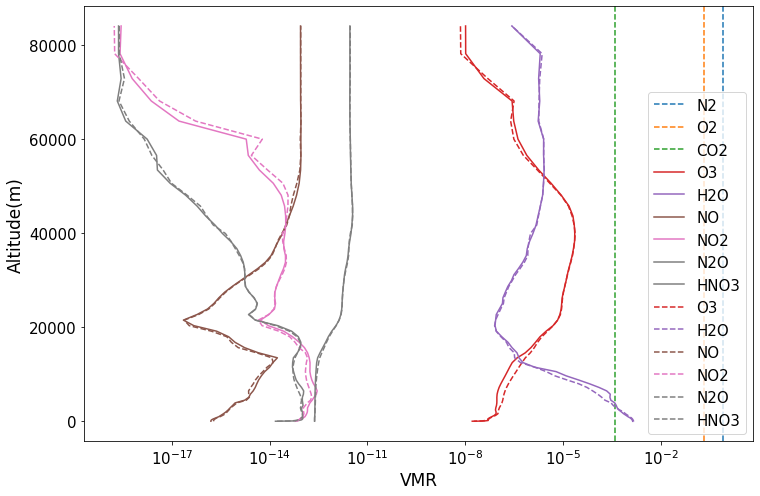

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


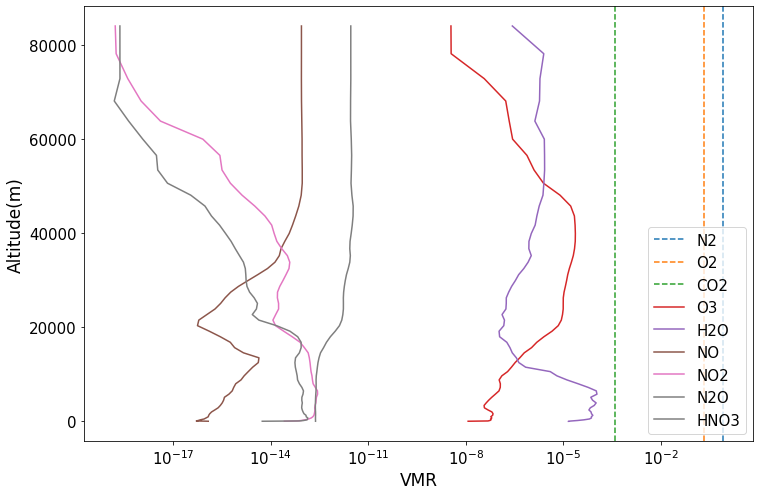

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


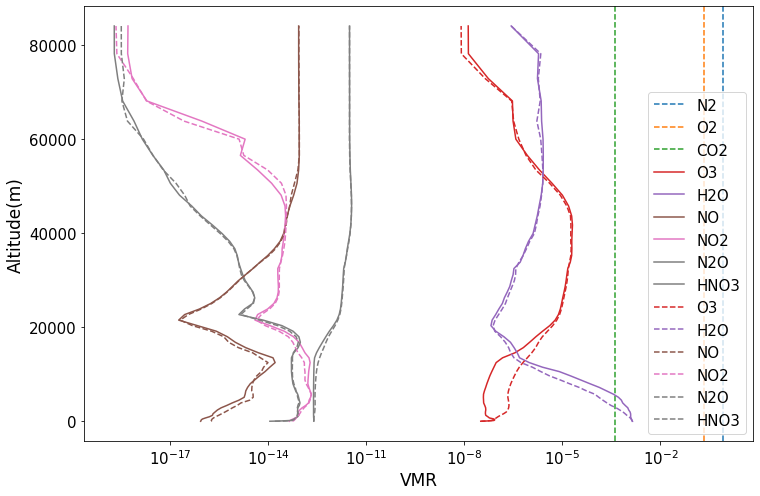

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


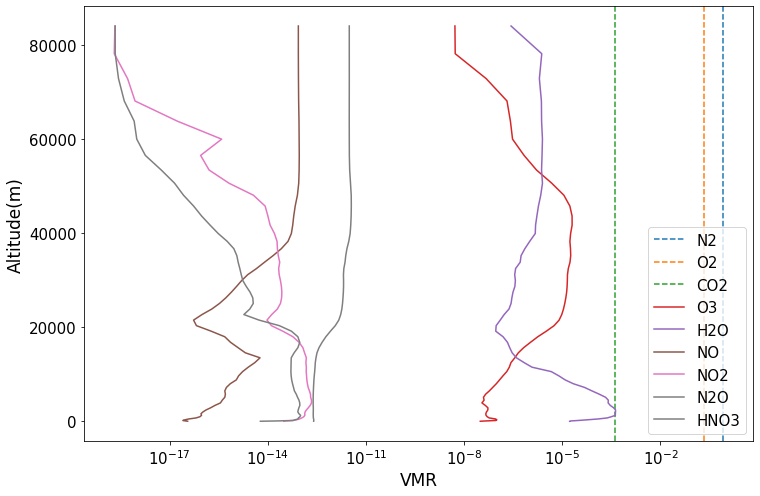

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


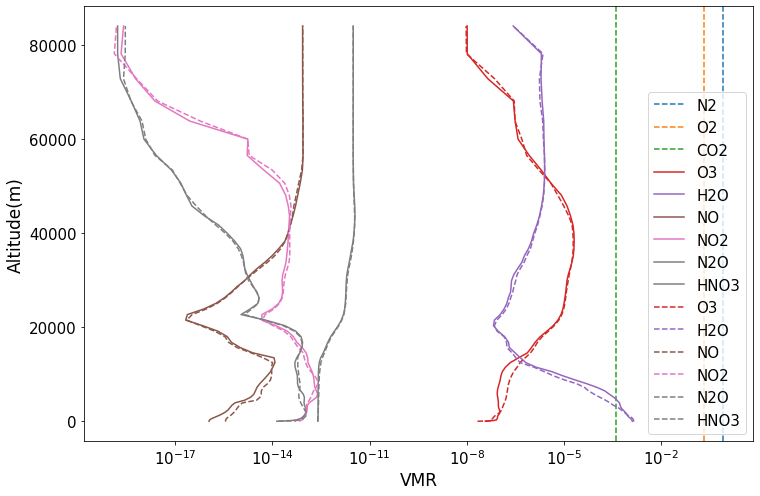

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


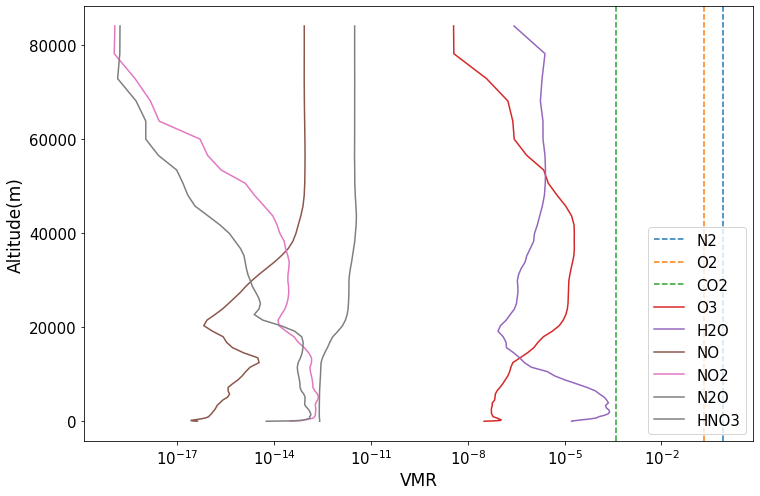

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


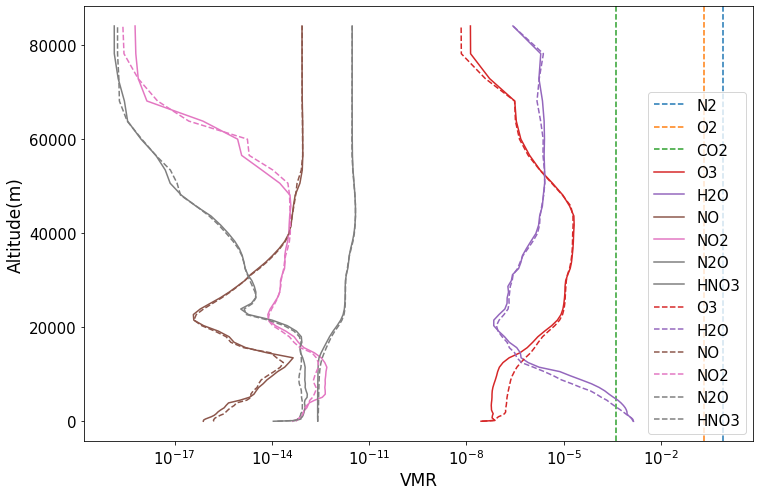

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


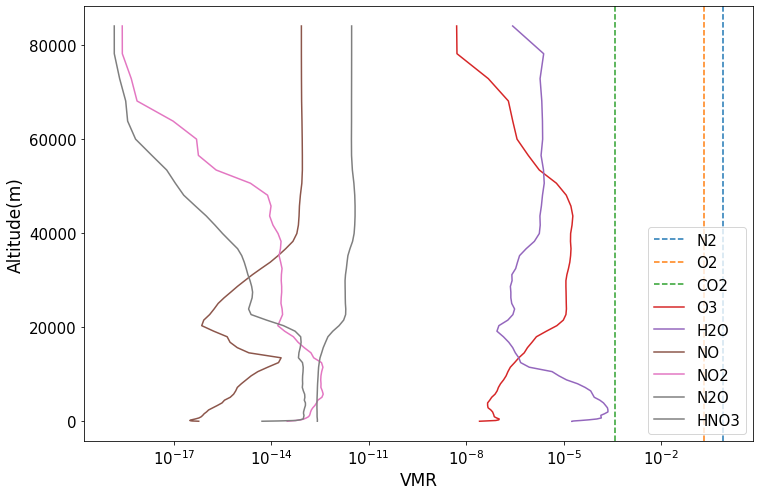

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


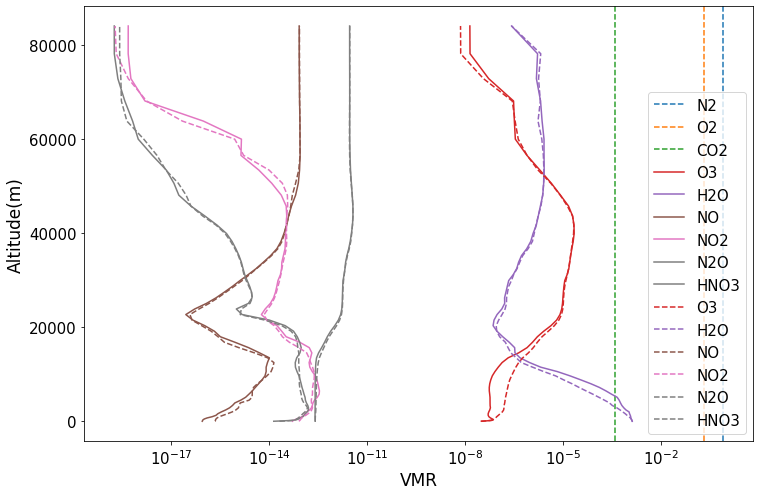

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


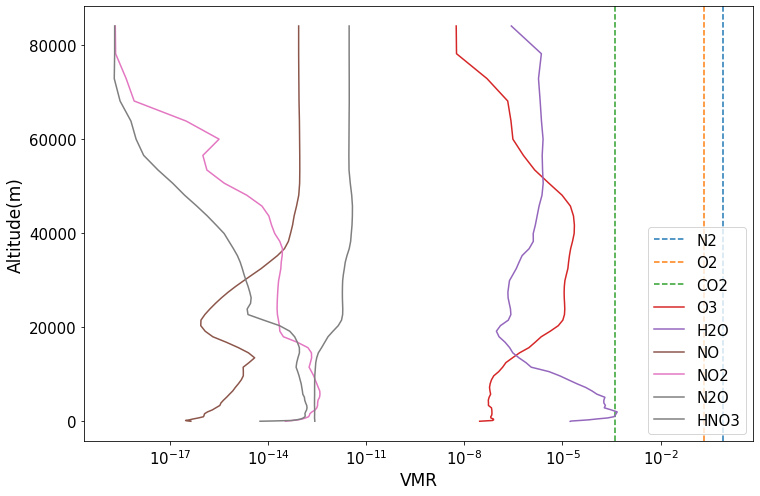

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


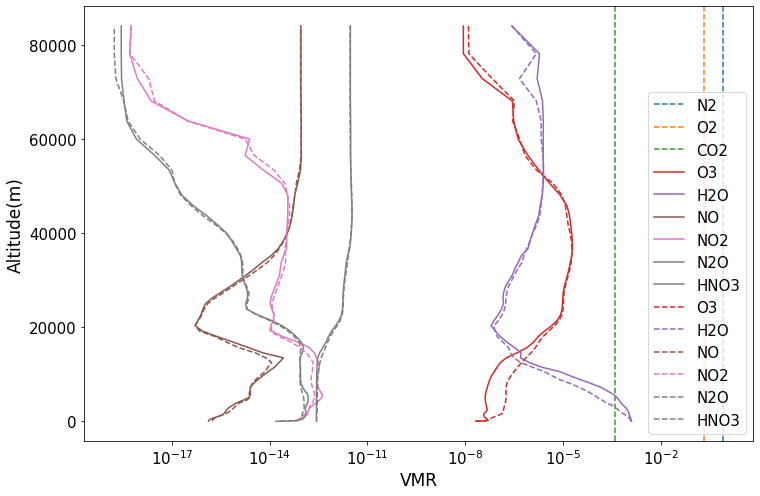

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


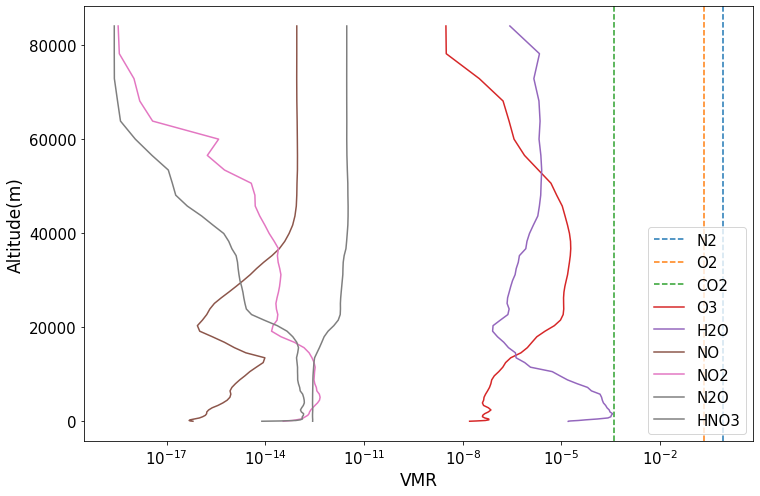

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


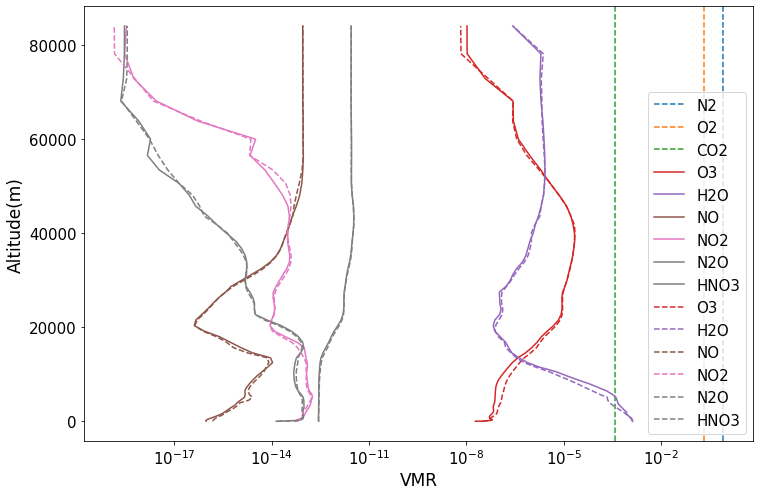

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


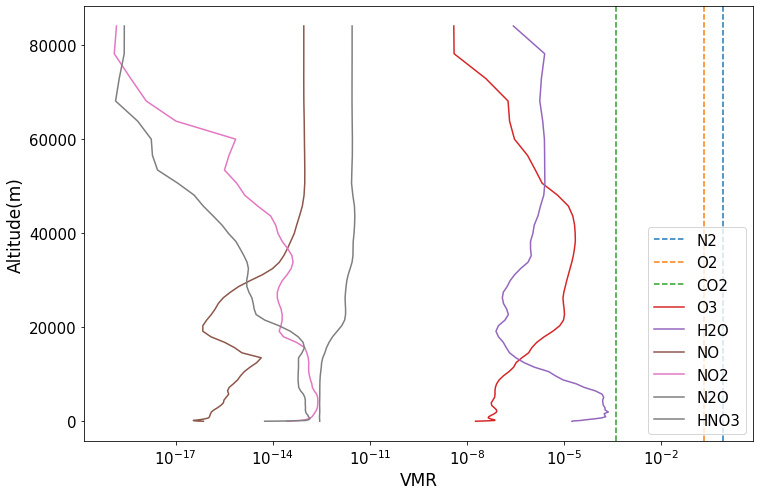

writing to PSG text file
replacement completed
generated PSG file
Used PSG API to generate spectrum
Clean up: predicting observations completed


In [130]:
plot_mixratz(pcb_b, time_slice_l=0, time_slice_u=1)
plot_mixratz(pcb_b, time_slice_l=0, time_slice_u=1, transmission=True)
plot_mixratz(pcb_b, time_slice_l=23, time_slice_u=24)
plot_mixratz(pcb_b, time_slice_l=23, time_slice_u=24, transmission=True)
plot_mixratz(pcb_b, time_slice_l=37, time_slice_u=38)
plot_mixratz(pcb_b, time_slice_l=37, time_slice_u=38, transmission=True)
plot_mixratz(pcb_b, time_slice_l=56, time_slice_u=57)
plot_mixratz(pcb_b, time_slice_l=56, time_slice_u=57, transmission=True)
plot_mixratz(pcb_b, time_slice_l=61, time_slice_u=62)
plot_mixratz(pcb_b, time_slice_l=61, time_slice_u=62, transmission=True)
plot_mixratz(pcb_b, time_slice_l=103, time_slice_u=104)
plot_mixratz(pcb_b, time_slice_l=103, time_slice_u=104, transmission=True)
plot_mixratz(pcb_b, time_slice_l=147, time_slice_u=148)
plot_mixratz(pcb_b, time_slice_l=147, time_slice_u=148, transmission=True)

In [5]:
pcb_1=pd.read_csv('PSG/synch/psg_spec_hemi_0_1.txt', skiprows=12,nrows=230, delim_whitespace=True,
                   names=['wave', 'total', 'noise', 'stellar', 'planet'])
pcb_1['wave'] = pcb_1['wave'].astype('float')
pcb_24=pd.read_csv('PSG/synch/psg_spec_hemi_23_24.txt', skiprows=12,nrows=230, delim_whitespace=True,
                   names=['wave', 'total', 'noise', 'stellar', 'planet'])
pcb_38=pd.read_csv('PSG/synch/psg_spec_hemi_37_38.txt', skiprows=12,nrows=230, delim_whitespace=True,
                   names=['wave', 'total', 'noise', 'stellar', 'planet'])
pcb_57=pd.read_csv('PSG/synch/psg_spec_hemi_56_57.txt', skiprows=12,nrows=230, delim_whitespace=True,
                   names=['wave', 'total', 'noise', 'stellar', 'planet'])
pcb_62=pd.read_csv('PSG/synch/psg_spec_hemi_61_62.txt', skiprows=12,nrows=230, delim_whitespace=True,
                   names=['wave', 'total', 'noise', 'stellar', 'planet'])
pcb_104=pd.read_csv('PSG/synch/psg_spec_hemi_103_104.txt', skiprows=12,nrows=230, delim_whitespace=True,
                   names=['wave', 'total', 'noise', 'stellar', 'planet'])
pcb_148=pd.read_csv('PSG/synch/psg_spec_hemi_147_148.txt', skiprows=12,nrows=230, delim_whitespace=True,
                   names=['wave', 'total', 'noise', 'stellar', 'planet'])


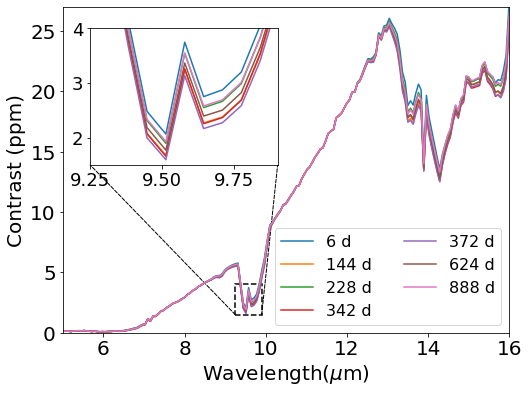

In [8]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(pcb_1['wave'], pcb_1['total'],label='6 d')
ax.plot(pcb_24['wave'], pcb_24['total'],label='144 d')
ax.plot(pcb_38['wave'], pcb_38['total'],label='228 d')
ax.plot(pcb_57['wave'], pcb_57['total'],label='342 d')
ax.plot(pcb_62['wave'], pcb_62['total'],label='372 d')
ax.plot(pcb_104['wave'], pcb_104['total'],label='624 d')
ax.plot(pcb_148['wave'], pcb_148['total'],label='888 d')

ax.legend(loc='lower right', fontsize=16, ncol=2)
ax.set_xlabel('Wavelength($\mu$m)', size=18)
ax.set_ylabel('Contrast (ppm)', size=18)
ax.tick_params(axis='both', which='major', labelsize=16)

# Set the initial limits for the plot
initial_xlim = ax.get_xlim()  # Get the current x-axis limits
initial_ylim = ax.get_ylim()  # Get the current y-axis limits

# Define the zoomed region
zoom_xlim = (9.25, 9.9)  # Set the desired x-axis limits for zooming
zoom_ylim = (1.5, 4)  # Set the desired y-axis limits for zooming

# Perform the zoom by updating the plot limits
ax.set_xlim(5,16)
ax.set_ylim(0,27)

# Create the inset plot for the zoomed region
inset_ax = inset_axes(ax, width="42%", height="42%", loc='upper left',
                     bbox_to_anchor=(0.05,-0.05,1,1), bbox_transform=ax.transAxes)
inset_ax.plot(pcb_1['wave'], pcb_1['total'])
inset_ax.plot(pcb_24['wave'], pcb_24['total'],label='24')
inset_ax.plot(pcb_38['wave'], pcb_38['total'],label='38')
inset_ax.plot(pcb_57['wave'], pcb_57['total'],label='57')
inset_ax.plot(pcb_62['wave'], pcb_62['total'],label='62')
inset_ax.plot(pcb_104['wave'], pcb_104['total'],label='104')
inset_ax.plot(pcb_148['wave'], pcb_148['total'],label='148')
inset_ax.set_xlim(zoom_xlim)
inset_ax.set_ylim(zoom_ylim)
#inset_ax.set_title('Zoomed In')
inset_ax.tick_params(axis='both', which='major', labelsize=15)

# Draw a box around the zoomed region in the larger plot
zoom_box = plt.Rectangle((zoom_xlim[0], zoom_ylim[0]), zoom_xlim[1] - zoom_xlim[0], zoom_ylim[1] - zoom_ylim[0],
                         facecolor='none', edgecolor='black', linewidth=1.5, linestyle='--')
ax.add_patch(zoom_box)

 # Add lines connecting the zoom box to the inset plot
line_kwargs = {'color': 'black', 'linewidth': 1.0, 'linestyle': '--'}
line1 = ConnectionPatch(xyA=(zoom_xlim[0], zoom_ylim[0]), xyB=(zoom_xlim[0], zoom_ylim[0]),
                        coordsA='data', coordsB='data', axesA=ax, axesB=inset_ax, **line_kwargs)
line2 = ConnectionPatch(xyA=(zoom_xlim[0], zoom_ylim[1]), xyB=(zoom_xlim[0], zoom_ylim[1]),
                        coordsA='data', coordsB='data', axesA=ax, axesB=inset_ax, **line_kwargs)
line3 = ConnectionPatch(xyA=(zoom_xlim[1], zoom_ylim[1]), xyB=(zoom_xlim[1], zoom_ylim[1]),
                        coordsA='data', coordsB='data', axesA=ax, axesB=inset_ax, **line_kwargs)
line4 = ConnectionPatch(xyA=(zoom_xlim[1], zoom_ylim[0]), xyB=(zoom_xlim[1], zoom_ylim[0]),
                        coordsA='data', coordsB='data', axesA=ax, axesB=inset_ax, **line_kwargs)
ax.add_artist(line1)
#ax.add_artist(line2)
#ax.add_artist(line3)
ax.add_artist(line4)

plt.savefig('pcb_emission.pdf', bbox_inches='tight')
plt.show()